In [ ]:
# import required packages
import tensorflow as tf
import cv2
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import PosixPath

In [2]:
# Function to display extracted files
def display_extracted_frames(num_rows, num_cols, list_frames):

    """
    Display function to show extracted frames from the video

    Args:
      num_rows: Number of rows to construct the subplot.
      num_cols: Number of columns to construct the subplot.
      list_frames: List of frames to be displayed.

    Return:
      Display the subplot
    """
    # Create a Matplotlib figure and subplots
    _, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))  # Adjust figsize as needed

    # Flatten the 2D array of subplots to make it easier to iterate through
    axes = axes.flatten()

    # Iterate through the image paths and display each image on a subplot
    for count, frame in enumerate(list_frames):
        if count < num_rows * num_cols:
            # Display the image on the current subplot
            axes[count].imshow(frame)
            axes[count].set_title(f'Image {count + 1}')
            # Turn off axis labels
            axes[count].axis('off')

    # Adjust the layout for better visualization
    plt.tight_layout()

    # Show the subplots
    plt.show()

In [3]:
class FrameGenerator:
    def __init__(self, path, n_frames, output_size, frame_step, selection_strategy, training = False):
        """ Returns a set of frames with their associated label. 

          Args:
            path: Video file paths.
            n_frames: Number of frames.
            selection_strategy: Provide which startegy to use for frame extraction
            we have support for 3 different stategies: 1. random, 2. dynamic and 3. smart_select
            training: Boolean to determine if training dataset is being created.
        """
        # print("path", path)
        self.path = path
        self.n_frames = n_frames
        self.output_size = output_size
        self.frame_step = frame_step
        self.selection_strategy = selection_strategy
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

        # print("self.class_names ", self.class_names)
        # print("self.class_ids_for_name ", self.class_ids_for_name)


    # Function that receive the video frame and output the padded and resized frame.
    def format_frames(self, frame):
        """
        Pad and resize an image from a video.

        Args:
        frame: Image that needs to resized and padded.
        output_size: Pixel size of the output frame image.

        Return:
        Formatted frame with padding of specified output size.
        """
        try:
            frame = tf.image.convert_image_dtype(frame, tf.float32)
            frame = tf.image.resize_with_pad(frame, *self.output_size)
            return frame
            
        except tf.errors.InvalidArgumentError as e:
            # Handle the specific exception raised when the conversion fails
            print(f"Error converting image data type: {e}")
        except Exception as e:
            # Handle other exceptions that might occur
            print(f"An unexpected error occurred: {e}")

    def nth_max_score(self, scores, n):
        # sort the list in descending order
        sorted_scores = sorted(scores, reverse=True)
    
        # Check if n is within the valid range
        if 1 <= n <= len(sorted_scores):
            return sorted_scores[n - 1]
        else:
            return f"Invalid value of n. It should be between 1 and {len(sorted_scores)}."


    def count_pixels_greater_than_value(self, image, value):
        return sum(pixel > value for row in image for pixel in row)


    def select_frame_on_score_dynamic_approach(self, src, video_length):
        results = []
        scores = []
        previous_heatmap = None

        src.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, previous_frame = src.read()
        
        # ret is a boolean indicating whether read was successful, frame is the image itself
        for _ in range(0, int(video_length) - 1, self.frame_step):
            for _ in range(self.frame_step):
                ret, frame = src.read()
            if not ret:
                frame = np.zeros_like(previous_frame)

            # Load two images
            image1 = previous_frame
            image2 = frame

            # Convert images to grayscale
            gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)*255
            gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)*255
    
            # Compute absolute difference between the two images
            diff = cv2.absdiff(gray1, gray2)
    
            diff = np.array(diff, dtype = np.uint8)
            
            non_zero_pixels_count = self.count_pixels_greater_than_value(image = diff, value = 15)
            
            # Create a heatmap using a color scale
            heatmap = cv2.applyColorMap(diff, cv2.COLORMAP_HOT)
            
            if previous_heatmap is None:
                previous_heatmap = heatmap

            results.append((previous_heatmap, frame, heatmap))
            scores.append(non_zero_pixels_count)
                    
            previous_heatmap = heatmap
            previous_frame   = frame

        src.release()

        threshold_score = self.nth_max_score(scores, self.n_frames)
        final_selected_frames = []
        for idx, score in enumerate(scores):
            if score >= threshold_score:
                final_selected_frames.append(self.format_frames(results[idx][1]))
        return final_selected_frames


    def select_frame_on_score_smart_approach(self, src, video_length):
        results = []
        scores = []
        previous_heatmap = None

        src.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, previous_frame = src.read()
        
        # ret is a boolean indicating whether read was successful, frame is the image itself
        for _ in range(0, int(video_length) - 1, self.frame_step):
            for _ in range(self.frame_step):
                ret, frame = src.read()
            if not ret:
                frame = np.zeros_like(previous_frame)

            # Load two images
            image1 = previous_frame
            image2 = frame

            # print("image", image1.shape, image2.shape)
            
            # Convert images to grayscale
            gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)*255
            gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)*255
    
            # Compute absolute difference between the two images
            diff = cv2.absdiff(gray1, gray2)

            # Apply thresholding
            _, binary_mask = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
            non_zero_pixels_count = np.sum(binary_mask)
            
            # Create a heatmap using a color scale
            # heatmap = cv2.applyColorMap(diff, cv2.COLORMAP_HOT)
            
            # if previous_heatmap is None:
                # previous_heatmap = heatmap

            results.append(frame)
            scores.append(non_zero_pixels_count)
                    
            # previous_heatmap = heatmap
            previous_frame   = frame

        src.release()

        threshold_score = self.nth_max_score(scores, self.n_frames)
        final_selected_frames = []
        for idx, score in enumerate(scores):
            if score >= threshold_score:
                final_selected_frames.append(self.format_frames(results[idx]))
        return final_selected_frames

    
    # Function that convert the received input video and output constant number of frames.
    def frames_from_video_file(self, video_path):
        """
        Creates frames from each video file present for each category.

        Args:
        video_path: File path to the video.
        selection_strategy: Provide which startegy to use for frame extraction
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

        Return:
        An NumPy array of frames in the shape of (n_frames, height, width, channels).
        """
        # Read each video frame by frame
        result = []
        src = cv2.VideoCapture(str(video_path))

        video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
        print("video_length ", video_length)

        if self.selection_strategy == "random":
            need_length = 1 + (self.n_frames - 1) * self.frame_step

            if need_length > video_length:
                start = 0
            else:
                max_start = video_length - need_length
                start = random.randint(0, max_start + 1)

            src.set(cv2.CAP_PROP_POS_FRAMES, start)
            # ret is a boolean indicating whether read was successful, frame is the image itself
            ret, frame = src.read()
            result.append(self.format_frames(frame))

            for _ in range(self.n_frames - 1):
                for _ in range(self.frame_step):
                    ret, frame = src.read()
                if ret:
                    frame = self.format_frames(frame)
                    result.append(frame)
                else:
                    result.append(np.zeros_like(result[0]))
            src.release()
            result = np.array(result)[..., [2, 1, 0]]

        elif self.selection_strategy == "dynamic":
            result = self.select_frame_on_score_dynamic_approach(src, video_length)

        elif self.selection_strategy == "smart_select":
            result = self.select_frame_on_score_smart_approach(src, video_length)

        else:
            print("The provided stategy is not valid, choose among these: 'random', 'dynamic' or 'smart_select'")

        return result

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.frames_from_video_file(video_path = path)
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label

In [4]:
video_path = PosixPath("/home/armnn/Music/ESML/project/kkk")

frame_extractor = FrameGenerator(path = video_path, n_frames = 60, output_size = (224, 224), frame_step = 5, selection_strategy = 'random')
start_time = time.time()
random_frames, label = next(frame_extractor())
end_time = time.time()
print("total time taken:", end_time - start_time)

video_length  3699.0


2023-12-06 00:22:03.771371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


total time taken: 0.39076757431030273


In [6]:
frame_extractor = FrameGenerator(path = video_path, n_frames = 60, output_size = (224, 224), frame_step = 5, selection_strategy = 'dynamic')
start_time = time.time()
dynamic_frames, label = next(frame_extractor())
end_time = time.time()
print("total time taken:", end_time - start_time)

video_length  3699.0
total time taken: 159.86067485809326


In [8]:
frame_extractor = FrameGenerator(path = video_path, n_frames = 60, output_size = (224, 224), frame_step = 5, selection_strategy = 'smart_select')
start_time = time.time()
samrt_frames, label = next(frame_extractor())
end_time = time.time()
print("total time taken:", end_time - start_time)

video_length  3699.0
total time taken: 0.667738676071167


In [ ]:
# for frame in final_selected_frames:
#     # Display the original images and the heatmap
#     plt.subplot(141), plt.imshow(cv2.cvtColor(frame[0], cv2.COLOR_BGR2RGB)), plt.title('previous Heatmap')
#     plt.subplot(142), plt.imshow(cv2.cvtColor(frame[1], cv2.COLOR_BGR2RGB)), plt.title('Image 1')
#     plt.subplot(143), plt.imshow(cv2.cvtColor(frame[2], cv2.COLOR_BGR2RGB)), plt.title('Image 2')
#     plt.subplot(144), plt.imshow(cv2.cvtColor(frame[3], cv2.COLOR_BGR2RGB)), plt.title('next Heatmap')
#     plt.show()

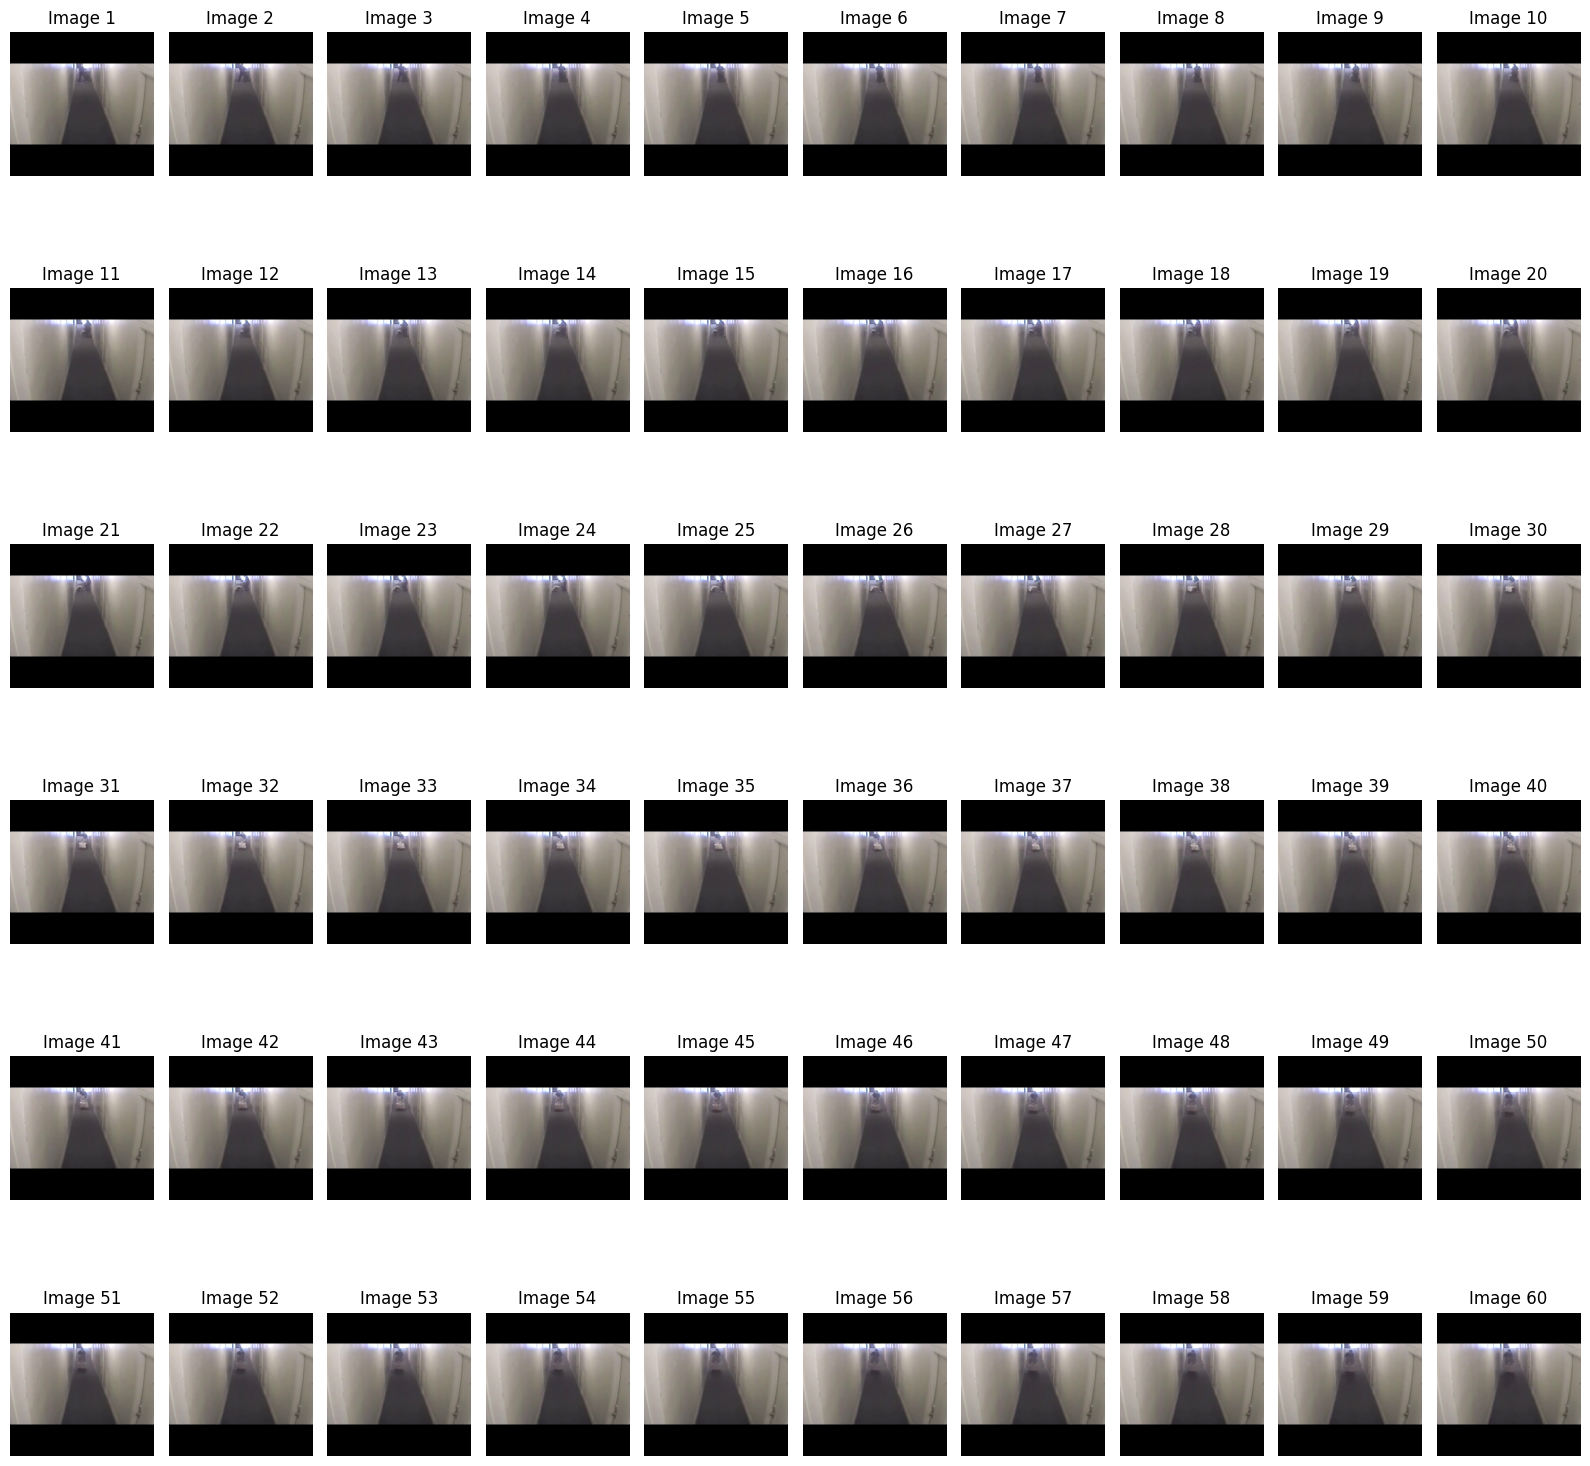

In [5]:
num_rows = 6  # Adjust the number of rows and columns as needed
num_cols = 10
display_extracted_frames(num_rows = num_rows, num_cols = num_cols, list_frames = random_frames)

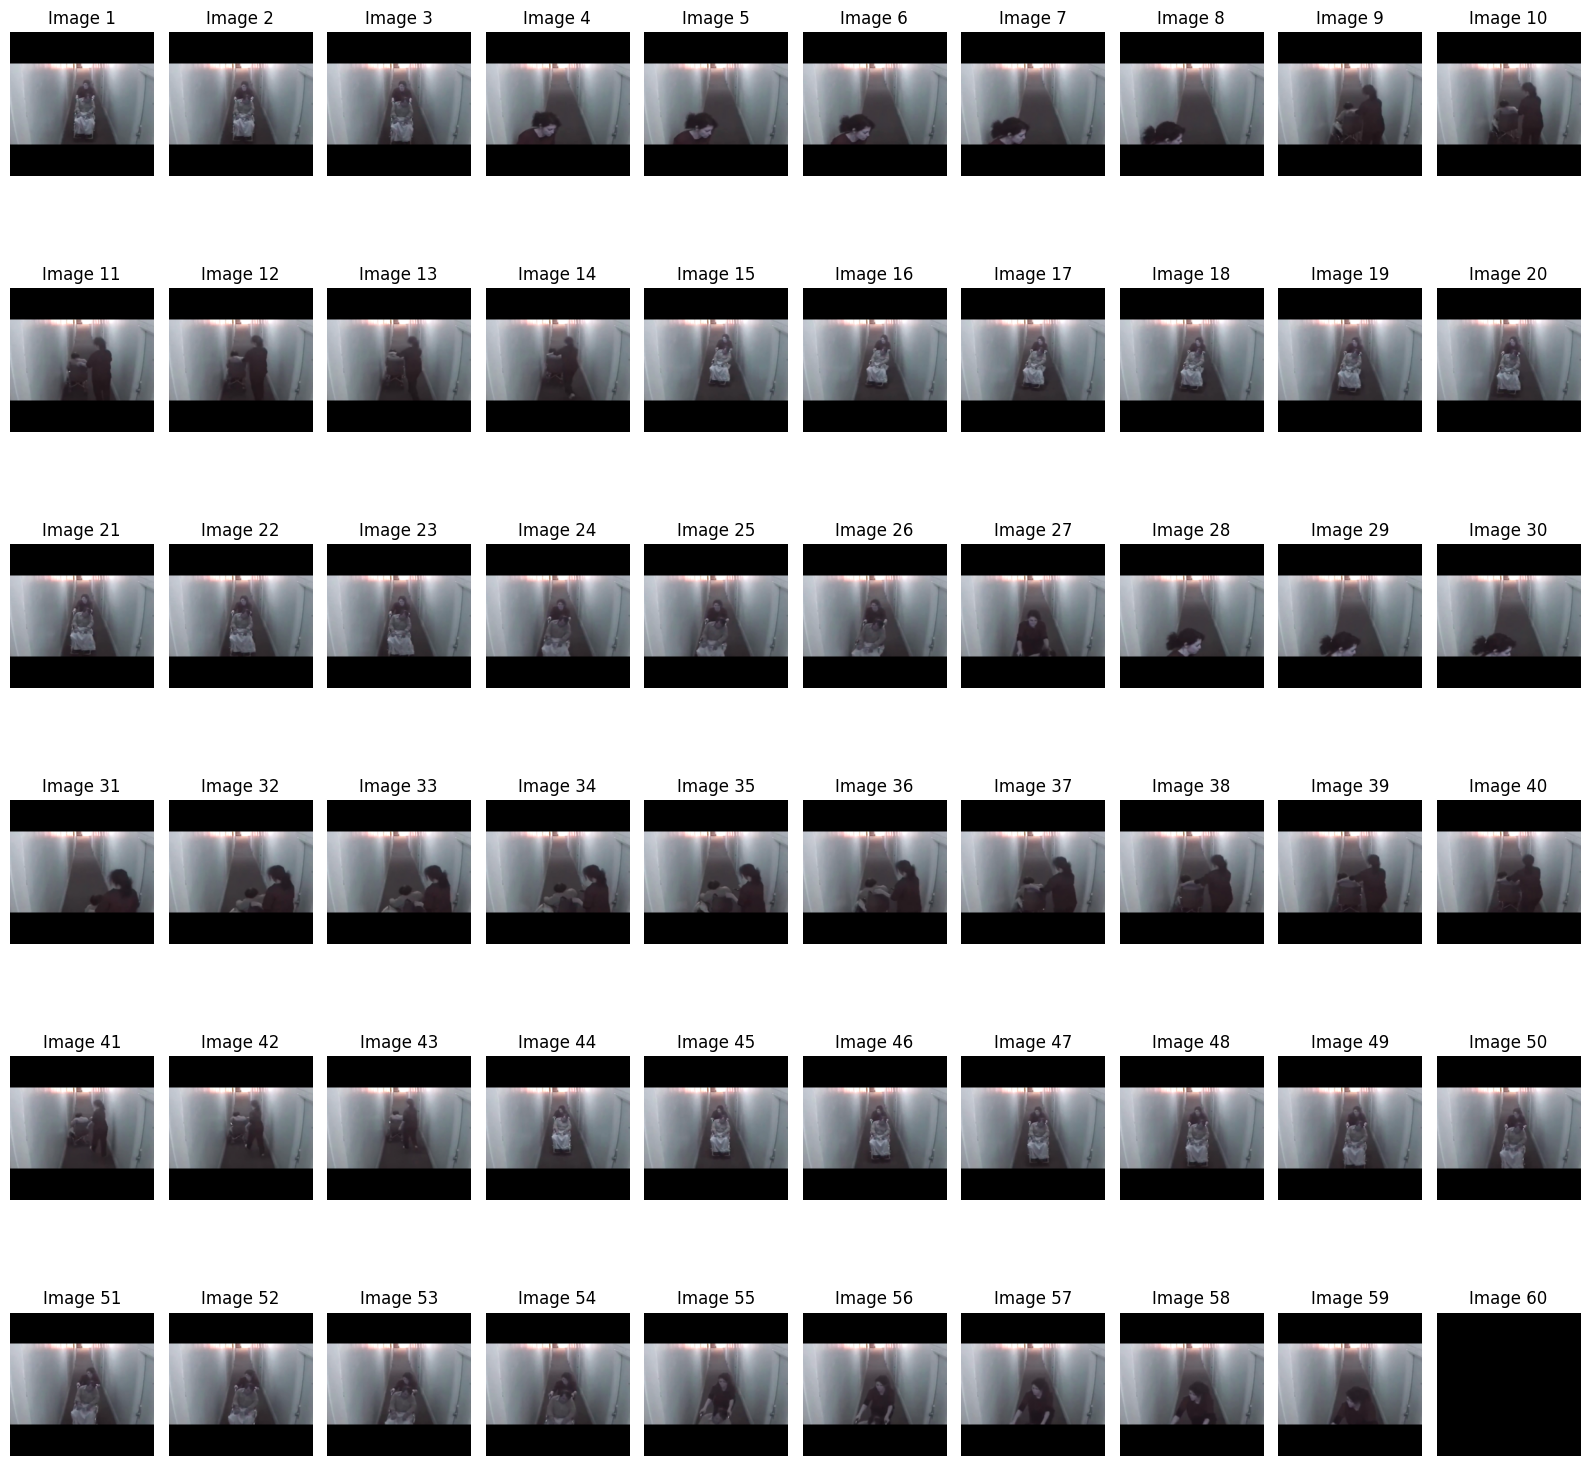

In [7]:
num_rows = 6  # Adjust the number of rows and columns as needed
num_cols = 10
display_extracted_frames(num_rows = num_rows, num_cols = num_cols, list_frames = dynamic_frames)

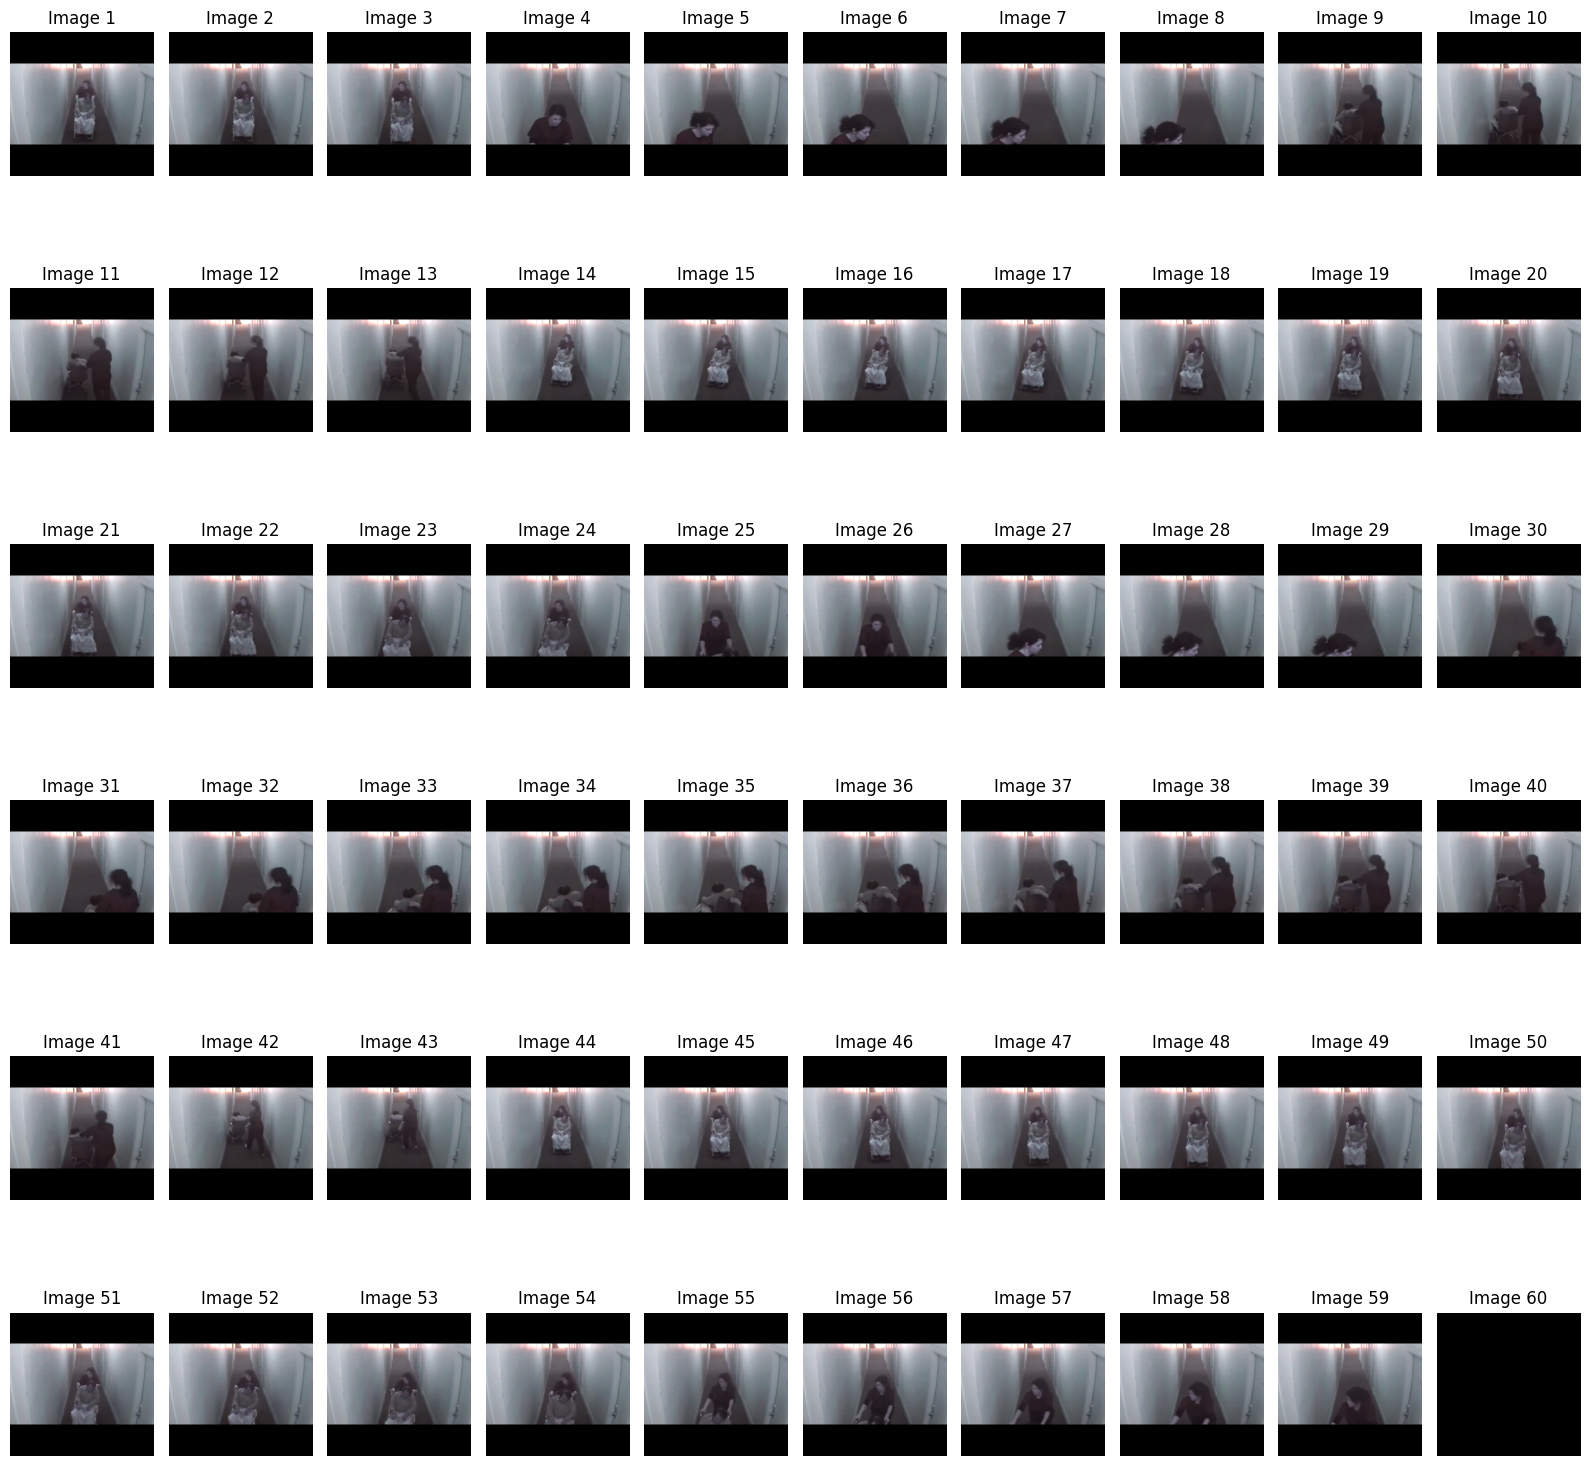

In [9]:
num_rows = 6  # Adjust the number of rows and columns as needed
num_cols = 10
display_extracted_frames(num_rows = num_rows, num_cols = num_cols, list_frames = samrt_frames)